# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Decision Tree, and will then apply a Decision Tree classsifier on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer
1. When we are using the information gain as our split method, we get the following tree:
    * we calculate H(S)=1
    * we calculate the information gain to each feature: 
        - G(S,X1) = 0.0817, G(S, X2) = 0, G(S,x3)=0 so we choose X1 as our best feature.
    * we calculate the information gain while X1=1 (as we can see if x1=0 so y=0):
        - G(S,X2) = 0.2516, G(S,X3) = 0.2516 so we choose arbitrarily one of them.
        
Now we get to depth 2 so we have to stop.

* Assume we chose X2 as our second feature, we know for sure that if x1=1 and x2=0 then y=1. But if x1=1 and x2=1 we have to get a descition:
    * If we decide y=0 we get training error of the resulting decision tree is 1/4 [(1,1,1) is wrong]
    * If we decide y=1 we get training error of the resulting decision tree is 1/4 [(1,0,0) is wrong]
    
* On the other case- Assume we chose X3 as our second feature, we know for sure that if x1=1 and x3=1 then y=1. But if x1=1 and x3=0 we have to get a descition:
    * If we decide y=0 we get training error of the resulting decision tree is 1/4 [(1,0,0) is wrong]
    * If we decide y=1 we get training error of the resulting decision tree is 1/4 [(1,1,0) is wrong]
    
    
2. To get a descition tree with zero training error we need to start from other feature:
    * X2---> 0 ---> X3---> 0         y=1
    * X2---> 0 ---> X3---> 1         y=0
    * X2---> 1 ---> X3---> 0         y=0
    * X2---> 1 ---> X3---> 1         y=1

## Implementing Decision Tree From Scratch
In this exercise you will need to implement a simple version of Decision Tree from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes).

* Compelete the skeleton class below
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `min_leaf` is the minimal number of samples in each leaf node
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(nlgn)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* To check your decision tree implementation, use the boston dataset (`from sklearn.datasets import load_boston`) split the data set into train and test using (`from sklearn.model_selection import train_test_split`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
    for min_leaf in [1,5,10,100]:
      dt = DecisionTree(X, y, n, sz, min_leaf)
      mse = # mean square error over test set
      print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = dt.predict(X_train)  # forest is the chosen model
  plt.scatter(y_hat, y_test)
  ```

In [1]:
import numpy as np

class DecisionTree():
    def __init__(self, X, y, n_trees=1, min_leaf=2, max_depth=2):
        self.n_trees = n_trees
        self.min_leaf = min_leaf #minimal number of samples in leaf 
        self.max_depth = max_depth
        self.X_train = X
        self.y_train = y
        self.root = None
        
    def fit(self):
        self.root = self.build_tree(self.X_train, self.y_train)
        
    def build_tree(self, X_train, y_train, cur_depth=0):
        if X_train.shape[0] <= self.min_leaf or cur_depth == self.max_depth:
            return {'prediction': round(self.calc_leaf_value(y_train),3)}
        
        result, left_indexes, right_indexes = self.get_best_split(X_train, y_train)
        result['left'] = self.build_tree(X_train[left_indexes], y_train[left_indexes], cur_depth+1)
        result['right'] = self.build_tree(X_train[right_indexes], y_train[right_indexes], cur_depth+1)
        return result
        
    def calc_splitting_critea(self, left_y, right_y):
        total_y = len(left_y) + len(right_y)
        weight_left = len(left_y)/total_y
        weight_right = len(right_y)/total_y
        total_var = weight_left * np.var(left_y) + weight_right * np.var(right_y)
        return total_var
    
    def split_samples(self, X, feature_index, threshold):
        left_samples_indexes = np.where(X[:, feature_index]<= threshold)[0]
        right_samples_indexes = np.where(X[:, feature_index]> threshold)[0]
        return left_samples_indexes, right_samples_indexes

    def get_best_split(self, X_train, y_train):
        best_feature = None
        best_treshold = None
        best_var_red = float("inf")
        left_indexes = None
        right_indexes = None
        
        for feature_index in range(X_train.shape[1]):
            feature_values = X_train[:, feature_index]
            possible_tresholds = np.unique(feature_values)
            
            for threshold in possible_tresholds:
                left_samples_indexes, right_samples_indexes = self.split_samples(X_train, feature_index, threshold)
                left_samples, right_samples = X_train[left_samples_indexes], X_train[right_samples_indexes]
                left_y, right_y = y_train[left_samples_indexes], y_train[right_samples_indexes]
                current_var_red = self.calc_splitting_critea(left_y, right_y)
                if current_var_red < best_var_red:
                    best_var_red = current_var_red
                    best_treshold = threshold
                    best_feature = feature_index
                    left_indexes = left_samples_indexes
                    right_indexes = right_samples_indexes
                    
        result = {'feature': best_feature, 'threshold': best_treshold}             
        return result, left_indexes, right_indexes
    
    def calc_leaf_value(self, y):
        y_mean = np.mean(y)
        return y_mean
                    
    def predict(self, X):
        all_predicts = []
        for x_sample in X:
            tree = self.root
            prediction = None
            
            while prediction is None:
                feature, threshold = tree['feature'], tree['threshold']
                if x_sample[feature] < threshold:
                    tree = tree['left']
                else:
                    tree = tree['right']
                prediction = tree.get('prediction', None)
            all_predicts.append(prediction)
        return all_predicts
        

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
np.seterr(all='ignore')

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

for min_leaf in [1,5,10,100]:
    dt = DecisionTree(X_train, y_train, 1, min_leaf,5)
    dt.fit()
    y_predict = dt.predict(X_test)
    mse = mean_squared_error(y_test, y_predict)# mean square error over test set
    print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))
    
print('The best hyper parameters are: min_leaf=5, max_depth=5')

/home/noyn/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


min_leaf:1 --- oob mse: 15.761838850393703


/home/noyn/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


min_leaf:5 --- oob mse: 11.9962138503937


/home/noyn/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


min_leaf:10 --- oob mse: 12.00378235433071


/home/noyn/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


min_leaf:100 --- oob mse: 20.13018843307087
The best hyper parameters are: min_leaf=5, max_depth=5


/home/noyn/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


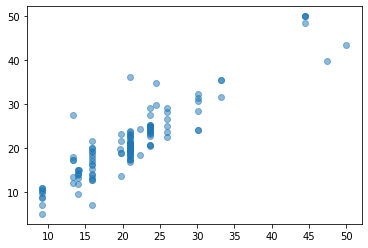

In [3]:
import matplotlib.pyplot as plt

dt = DecisionTree(X_train, y_train, 1, 5, 5)
dt.fit()
y_hat = dt.predict(X_test) 
plt.scatter(y_hat, y_test, alpha=0.5)

## Using Decision Treefor Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier`
- Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [4]:
# code and answer go here
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'Original train data shape: {x_train.shape}')
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
print(f'2 Dimentionals train data shape: {x_train.shape}')
print(f'Test size: {x_test.shape}')

Original train data shape: (60000, 28, 28)
2 Dimentionals train data shape: (60000, 784)
Test size: (10000, 784)


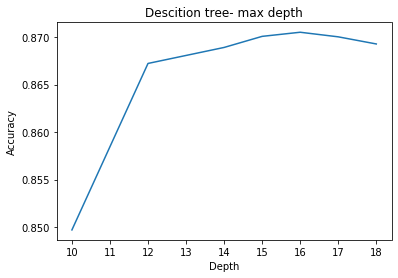

Best depth: 16 with accuracy: 0.8705


In [97]:
depths = [10, 12, 14, 15, 16, 17, 18]
depth_accuracy_scores = []
for depth in depths:
    clf_dt = DecisionTreeClassifier(max_depth=depth, random_state=10)
    scores = cross_val_score(clf_dt, x_train, y_train, cv=5)
    accuracy_cv = scores.mean()
    depth_accuracy_scores.append(accuracy_cv)

plt.plot(depths, depth_accuracy_scores)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title("Descition tree- max depth")
plt.show()
best_depth_dt = depths[np.argmax(depth_accuracy_scores)]
best_depth_accuracy_dt = np.max(depth_accuracy_scores)
print(f'Best depth: {best_depth_dt} with accuracy: {best_depth_accuracy_dt}')

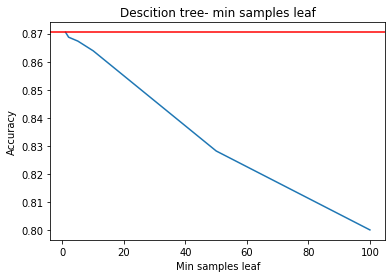

Best min leaf: 1 with accuracy: 0.8705


In [98]:
best_depth_accuracy = np.max(depth_accuracy_scores)
min_leafs = [1,2,5,10,50,100]
leaf_accuracy_scores = []
for min_leaf in min_leafs:
    clf_dt = DecisionTreeClassifier(max_depth=best_depth_dt, min_samples_leaf= min_leaf, random_state=10)
    scores = cross_val_score(clf_dt, x_train, y_train, cv=5)
    accuracy_cv = scores.mean()
    leaf_accuracy_scores.append(accuracy_cv)

plt.plot(min_leafs, leaf_accuracy_scores)
plt.axhline(y= best_depth_accuracy, color='r', linestyle='-')
plt.title("Descition tree- min samples leaf")
plt.xlabel('Min samples leaf')
plt.ylabel('Accuracy')
plt.show()
best_leaf_dt = min_leafs[np.argmax(leaf_accuracy_scores)]
best_leaf_accuracy_dt = np.max(leaf_accuracy_scores)
print(f'Best min leaf: {best_leaf_dt} with accuracy: {best_leaf_accuracy_dt}')

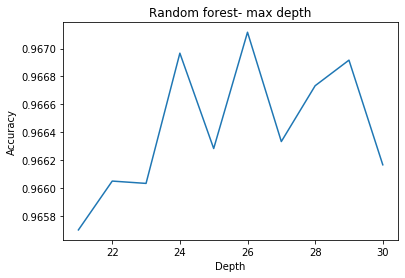

Best depth: 26 with accuracy: 0.9671166666666666


In [22]:
depths = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
depth_accuracy_scores = []
for depth in depths:
    clf_rf = RandomForestClassifier(max_depth=depth, random_state=10)
    scores = cross_val_score(clf_rf, x_train, y_train, cv=5)
    accuracy_cv = scores.mean()
    depth_accuracy_scores.append(accuracy_cv)

plt.plot(depths, depth_accuracy_scores)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title("Random forest- max depth")
plt.show()
best_depth_rf = depths[np.argmax(depth_accuracy_scores)]
best_depth_accuracy_rf = np.max(depth_accuracy_scores)
print(f'Best depth: {best_depth_rf} with accuracy: {best_depth_accuracy_rf}')

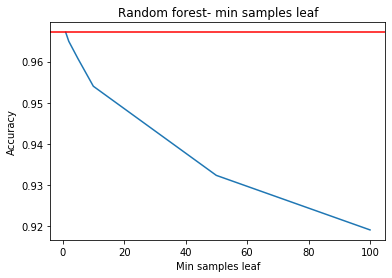

Best min leaf: 1 with accuracy: 0.9671166666666666


In [24]:
min_leafs = [1,2,5,10,50,100]
leaf_accuracy_scores = []
for min_leaf in min_leafs:
    clf_dt = RandomForestClassifier(max_depth=best_depth_rf, min_samples_leaf= min_leaf, random_state=10)
    scores = cross_val_score(clf_dt, x_train, y_train, cv=5)
    accuracy_cv = scores.mean()
    leaf_accuracy_scores.append(accuracy_cv)

plt.plot(min_leafs, leaf_accuracy_scores)
plt.axhline(y= best_depth_accuracy_rf, color='r', linestyle='-')
plt.title("Random forest- min samples leaf")
plt.xlabel('Min samples leaf')
plt.ylabel('Accuracy')
plt.show()
best_leaf_rf = min_leafs[np.argmax(leaf_accuracy_scores)]
best_leaf_accuracy_rf = np.max(leaf_accuracy_scores)
print(f'Best min leaf: {best_leaf_rf} with accuracy: {best_leaf_accuracy_rf}')

#### Choose which model parameters you wish to optimize, explain how would you do that?
- We decided to optimize the max_depth parameter. We did it because the original data is photo with pixels of 28* 28, but to use it in Decision tree we change the shape of data from 3 dimentions to 2 dimentions. So we assume that if we create a decision tree with max depth of the original features size (=28) the algorithem will find out the best features from the 2 dimentions data and create the best tree. For random forest we found that the use of 26 features gives the best result and on descition tree the use of 16 features gave the best results. The difference might because random forest split the data and create some trees and not one likt descition tree, it's accuracy is also higher.

- Another parameter we tried to optimize is the min_samples_leaf that's because we saw the difference in accuracy when we implemented our continues model. When we are using it with the best max depth we found in both cases it didnt improve our results, So we choose the default min samples leaf=1.

To exam our model parameters we use cross validation because  When evaluating different hyperparameters for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. To solve this problem, we used cross validation.

After examing the 2 models we can see that the random forest model is more accurate then the descition tree and it's the chosen model with hyperparameter of max_depth = 26

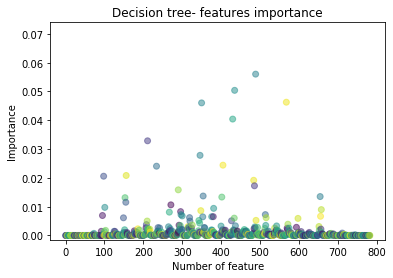

In [5]:
#Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
clf_dt = DecisionTreeClassifier(max_depth=14, random_state=10)
clf_dt.fit(x_train, y_train)
dt_feature_importances = clf_dt.feature_importances_
number_features = len(dt_feature_importances)
features_numbers = range(number_features)
colors = np.random.rand(number_features)
plt.scatter(features_numbers, dt_feature_importances, c=colors, alpha=0.5)
plt.ylim(ymin=-0.0015)
plt.title("Decision tree- features importance")
plt.xlabel('Number of feature')
plt.ylabel('Importance')
plt.show()

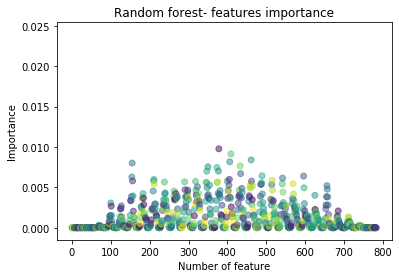

In [6]:
clf_rf = RandomForestClassifier(max_depth=26, random_state=10)
clf_rf.fit(x_train, y_train)
rf_feature_importances = clf_rf.feature_importances_
number_features = len(rf_feature_importances)
features_numbers = range(number_features)
colors = np.random.rand(number_features)
plt.scatter(features_numbers, rf_feature_importances, c=colors, alpha=0.5)
plt.ylim(ymin=-0.0015)
plt.title("Random forest- features importance")
plt.xlabel('Number of feature')
plt.ylabel('Importance')
plt.show()

#### Discuss your results
As we thought, there are some features that are more important then the other. In both models we can see that the feature on the edges (features that are smaller then 100 and higher then 700) are not important at all, thier value is 0, that's because they represent the pixels of the corners of the photo that don't help us to decide the digit label. 
As we saw before, the decision tree has small number of feature with high importance value, some of them has really high value between 0.4-0.6. The random forest gives, 2 times features from the second algorithm, high importance value but the difference is that the most high value there is 0.01 which means it did not relay on small group of features to define the split. The difference between the features importance in the algorithem is beacause of the way they work, decision tree create one tree from the train data and random forest split the train data and create some trees that are combined together. That's the rason why to random forest has more features with the same weight because it use in diffrent features for it's diffrent trees.

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       980
           1       0.95      0.96      0.96      1135
           2       0.88      0.86      0.87      1032
           3       0.85      0.86      0.85      1010
           4       0.88      0.88      0.88       982
           5       0.84      0.84      0.84       892
           6       0.90      0.88      0.89       958
           7       0.91      0.91      0.91      1028
           8       0.84      0.81      0.83       974
           9       0.85      0.87      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



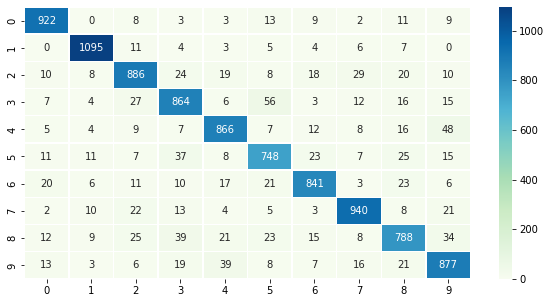

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_predict_dt = clf_dt.predict(x_test)
labels = clf_dt.classes_

plt.figure(figsize=(10,5))
confusion_matrix_dt = confusion_matrix(y_test, y_predict_dt, labels = labels)
sns.heatmap(confusion_matrix_dt, annot=True, cmap="GnBu", fmt="d", linewidths=0.5)
print(classification_report(y_test, y_predict_dt))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.96      0.96       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



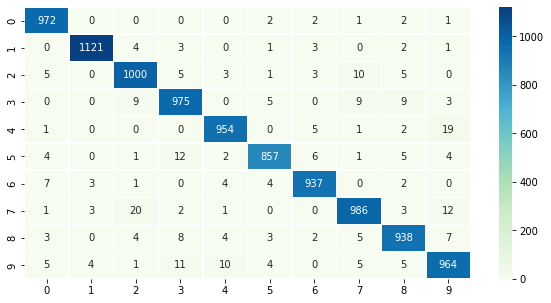

In [8]:
y_predict_rf = clf_rf.predict(x_test)
labels = clf_rf.classes_

plt.figure(figsize=(10,5))
confusion_matrix_rf = confusion_matrix(y_test, y_predict_rf, labels = labels)
sns.heatmap(confusion_matrix_rf, annot=True, cmap="GnBu", fmt="d", linewidths=0.5)
print(classification_report(y_test, y_predict_rf))

In [11]:
#Last, estimate the class assignment probabilities in your test data.
predicted_probs =  clf_rf.predict_proba(x_test)
p_correct = []
p_mistake = []
y_test_ints = np.array(y_test.astype(int))

for index, max_p in enumerate(np.argmax(predicted_probs, axis=1)):
    if max_p == y_test_ints[index]:
        p_correct.append(predicted_probs[index, max_p])
    else:
        p_mistake.append(predicted_probs[index, max_p])

print(f"The mean probability for correctly classified digits: {np.mean(p_correct)}")
print(f"The mean probability for misclassified digits: {np.mean(p_mistake)}")

The mean probability for correctly classified digits: 0.840120889226255
The mean probability for misclassified digits: 0.4002555784399463


#### Discuss your results
* As we can see, in Decision tree the accuracy of every label is low then the random forest accuracy, In addition we can see that to each label in decision tree there are several of labels that the algorithem can wrong with,for example: the digit 4 sometimes got diffrent labels: 0,1,2,3,4,5,6,7,8. The random forest is more specific, if it predict wrong the label most of the times it predict 2 or 3 other of diffrent labels- for example: the digit 4 sometimes got diffrent label of:6,9. In addition to the accuracy value that's can show us that the algorithem is more precise then the decision tree.

* The mean probs for the chosen model are mean correct classified digit = 0.84 and miisclassified digit=0.4 the meanning is that there is 2 times highe chance to predict the digit right then to get an incorrect answer.